# Initilization

In [91]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import subprocess
import shlex
from datetime import datetime

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

from kaggle.api.kaggle_api_extended import KaggleApi

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("seaborn-whitegrid")
matplotlib.rcParams.update({'font.size': 15})

## Knowledge

<font size=4>Ref.:</font>

https://www.kaggle.com/c/liverpool-ion-switching

https://en.wikipedia.org/wiki/Ion_channel

http://book.bionumbers.org/how-many-ions-pass-through-an-ion-channel-per-second/

https://www.nature.com/articles/s42003-019-0729-3

https://journals.physiology.org/doi/full/10.1152/advan.00006.2002


| a|b|
|-|-|
|<img src="https://upload.wikimedia.org/wikipedia/commons/2/2f/Ion_channel.png" width="250"/> | <img src="http://book.bionumbers.org/wp-content/uploads/2014/08/427-f1-ChannelOpenClose-11.png" width="300"/>|

|c|
|-|
|<img src="http://book.bionumbers.org/wp-content/uploads/2014/08/427-f3-IonChannelCalc-1.png" width="560"/>|


- The opening of an ion channel is a fleeting event within a few milliseconds

- Single-channel records can be obtained using the appropriate electrophysiological technique (e.g., patch clamp), and from these records the open probability and the channel conductance can be calculated. 
***

<font size=4>Figure out the current through a single channel:</font>

- In a certain sweep (e.g. N=1000 points), use the differences ($y_i$) of succesive points along the sweep to calculate the variance, i.e.
$$y_i = \frac{1}{2}(x_i - x_{i+1})\tag{1}$$
where i is the current of the i-th point along the sweep. \
The variance is given by
$$\sigma_i^2 = \frac{2}{N-1}\sum_i^N (y_i - \bar{y})^2 \tag{2}$$
where $\bar{y}$ is the mean current of the sweep. We can get the plot:

<img src="https://www.researchgate.net/profile/Osvaldo_Alvarez2/publication/11024671/figure/fig5/AS:394575848984579@1471085621134/Plot-of-the-variance-vs-the-mean-current-computed-for-each-of-the-1-000-isochrones-of-a.png" width="400"/>

- The current through singe channel $i$ can be obtained by fitting the parabola with Eq. (2)

In [73]:
data = ions.X_test['signal'][1:1000].values
data_scaled = (data - data.min()) / (data.max() - data.min())

y = 0.5 * np.diff(data_scaled)
sigma2 = np.zeros((len(data)-1, 1), dtype=np.float32)

for i in range(1, len(data)):
    sigma2[i-1] = 2/(len(data) -1) * ((y[:i] - y.mean())**2).sum()

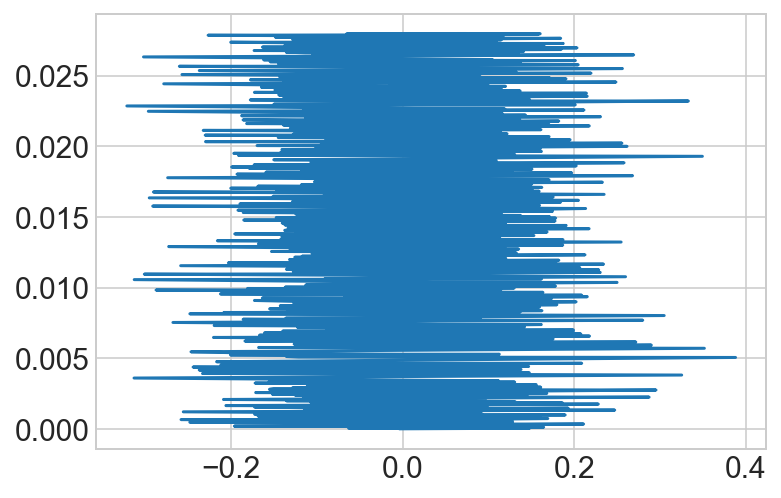

In [74]:
plt.plot(y, sigma2)

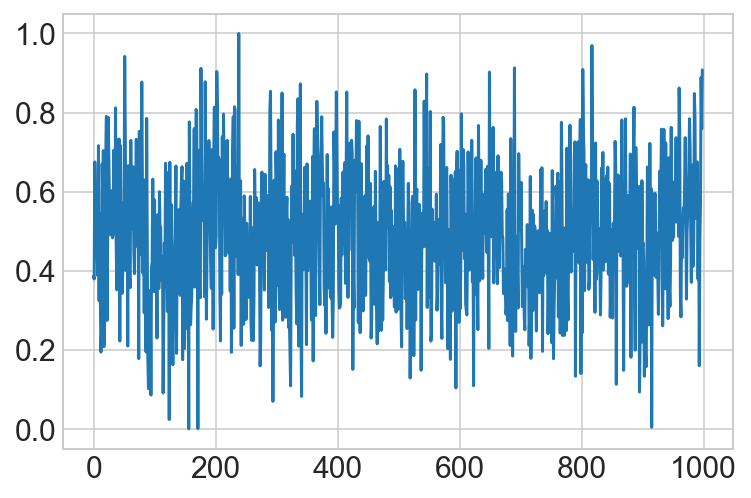

In [72]:
plt.plot(std)

## Feature Engineering

In [85]:
class KaggleCompete:
    """
    Pipeline for kaggle compete - Ion Switching
    """
    def __init__(self):
        # load data
        self.read_data()
        # parameters
        self.windows = [10, 50]
        self.batch_size = 10000

    ######################################################################
    # Load Data
    ######################################################################
    def read_data(self):

        self.train = pd.read_csv('./data/train_clean.csv',
                                 dtype={
                                     'time': np.float32,
                                     'signal': np.float32,
                                     'open_channels': np.int32
                                 })

        self.test = pd.read_csv('./data/test_clean.csv',
                                dtype={
                                    'time': np.float32,
                                    'signal': np.float32
                                })

        self.submit = pd.read_csv('./data/sample_submission.csv',
                                  dtype={'time': np.float32})

    ######################################################################
    # Feature Engineering
    ######################################################################
    def label_batch(self):
        # init
        n_samples = 100000  # 10s/sweep
        df_train, df_test = self.train, self.test

        # assign label
        df_train['label'] = 'train'
        df_test['label'] = 'test'

        # concatenate data
        self.data = pd.concat([self.train, self.test],
                              axis=0,
                              ignore_index=True)

        # assign label to batches
        num_batch = int(len(self.data) / n_samples)
        label = range(1, num_batch + 1)
        self.data['batch_idx'] = np.repeat(label, n_samples).astype(np.int32)

    def scale_batch(self):
        # scale signal for each batch
        scaler = MinMaxScaler()

        s_scaled = self.data.groupby('batch_idx')['signal'].apply(
            lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

        df_scaled = s_scaled.to_frame().explode('signal')
        self.data['signal_scaled'] = df_scaled['signal'].values.astype(
            np.float32)

    @staticmethod
    def create_rolling_features(df, windows):

        for window in windows:
            df["rolling_mean_" +
               str(window)] = df['signal'].rolling(window=window).mean()
            df["rolling_std_" +
               str(window)] = df['signal'].rolling(window=window).std()
#             df["rolling_var_" +
#                str(window)] = df['signal'].rolling(window=window).var()
            df["rolling_min_" +
               str(window)] = df['signal'].rolling(window=window).min()
            df["rolling_max_" +
               str(window)] = df['signal'].rolling(window=window).max()
            df["rolling_min_max_ratio_" +
               str(window)] = df["rolling_min_" +
                                 str(window)] / df["rolling_max_" +
                                                   str(window)]
            df["rolling_min_max_diff_" +
               str(window)] = df["rolling_max_" +
                                 str(window)] - df["rolling_min_" +
                                                   str(window)]

        df = df.replace([np.inf, -np.inf], np.nan)
        df.fillna(0, inplace=True)

        return df

    @staticmethod
    def create_group_features(df, windows, batch_size):

        df['group'] = df.groupby(df.index // batch_size,
                                 sort=False)['signal'].agg(['ngroup']).values
        df['group'] = df['group'].astype(np.uint16)

        # create leads and lags
        for window in windows:
            df['signal_shift_pos_' + str(window)] = df.groupby(
                'group')['signal'].shift(window).fillna(0)

            df['signal_shift_neg_' +
               str(window)] = df.groupby('group')['signal'].shift(
                   -1 * window).fillna(0)

        # squared signal
        df['signal_2'] = df['signal']**2

        return df

    def data_split(self):
        # prepare data for model training
        self.X_train = self.data[self.data.label == 'train'].drop(
            columns='open_channels')
        self.y_train = self.data[self.data.label == 'train']['open_channels']

        self.X_test = self.data[self.data.label == 'test'].drop(
            columns=['open_channels'])

    def feature_engineering(self, df):
        df = self.create_rolling_features(df, self.windows)
        df = self.create_group_features(df, self.windows, self.batch_size)
        return df

    def feature_selection(self, drop_list):
        self.X_train = self.X_train.drop(columns=drop_list)
        self.X_test = self.X_test.drop(columns=drop_list)


    ######################################################################
    # Submission
    ######################################################################
    def submit_result(self, model):
        y_pred = model.predict(self.X_test)
        filename = 'submission.csv'

        self.submit['open_channels'] = y_pred
        self.submit = self.submit.astype({'open_channels': np.int32})
        self.submit.to_csv(filename, index=False, float_format='%.4f')

## Models

In [80]:
######################################################################
# lightGBM Model
######################################################################
class ModelLGBM:
    def __init__(self):
        self.parameters = {
            "n_estimators": 3000,
            "learning_rates": 0.1,
            "max_depth": 7,
            "num_leaves": 2**7 + 1,
            "n_jobs": -1,
        }

    def cross_validation(self, X, y):
        cv = KFold(n_splits=10, random_state=None, shuffle=True)
        model = lgb.LGBMClassifier(**self.parameters)
        scores = cross_val_score(model, X, y, cv=5)

        return lgb_model

    def model(train, label):

        # initialize lightGBM model
        model = lgb.LGBMClassifier(**self.parameters)

        # split train valid sets
        X_train, X_valid, y_train, y_valid = train_test_split(train,
                                                              label,
                                                              test_size=0.2,
                                                              random_state=42)
        # fit the model
        model.fit(X_train,
                  y_train,
                  eval_set=(X_valid, y_valid),
                  early_stopping_rounds=150,
                  verbose=50)

        # validation
        y_pred = model.predict(X_valid)

        print(f'Validation score:', f1_score(y_valid, y_pred, average='macro'))

        return model


######################################################################
# Wavenet
######################################################################

# Exploratory data analysis (EDA)

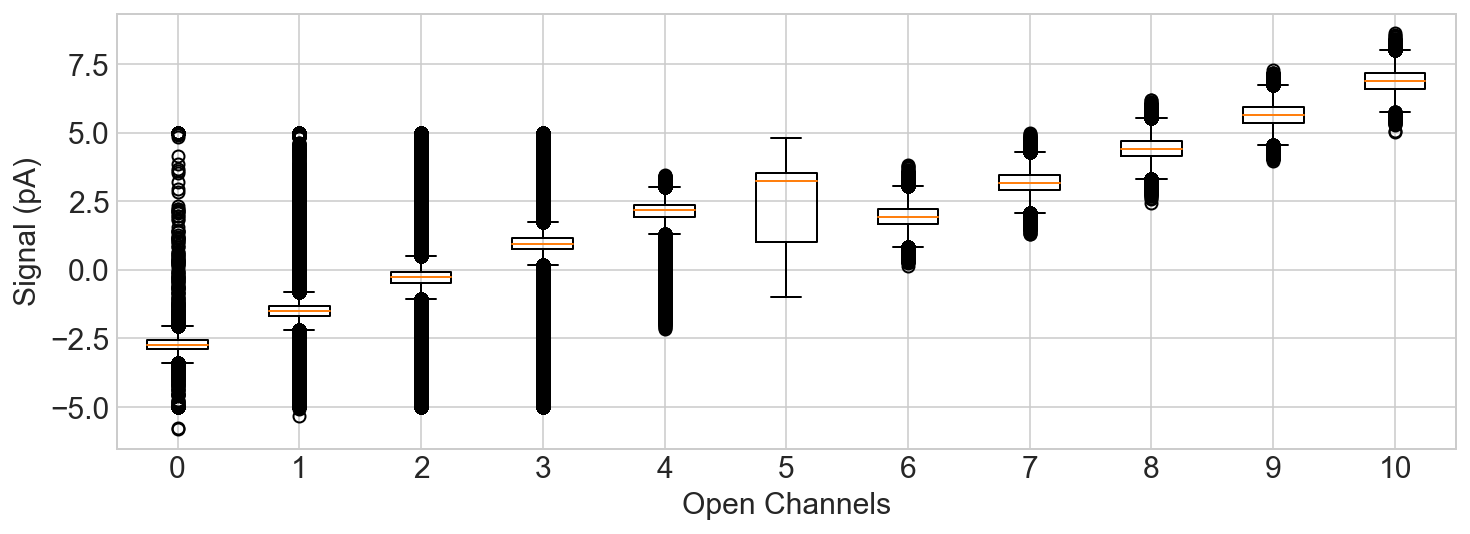

In [57]:
def boxplot_channel(df_train):
    # check quantiles of open channels corresponding to signal
    fig, ax = plt.subplots(1, 1, figsize= (12, 4))
    
    signal = []
    # sort number of channels
    n_channel = np.sort(df_train.open_channels.unique())
    
    # boxplots
    for val in n_channel:
        signal.append(df_train[df_train.open_channels == val].signal)
        
    ax.boxplot(signal)
    ax.set_xticklabels(n_channel)
    ax.set_xlabel('Open Channels')
    ax.set_ylabel('Signal (pA)')

    plt.show()

boxplot_channel(ions.train)

Number of training batches: 10.0
Signal Batch (fragment):  0


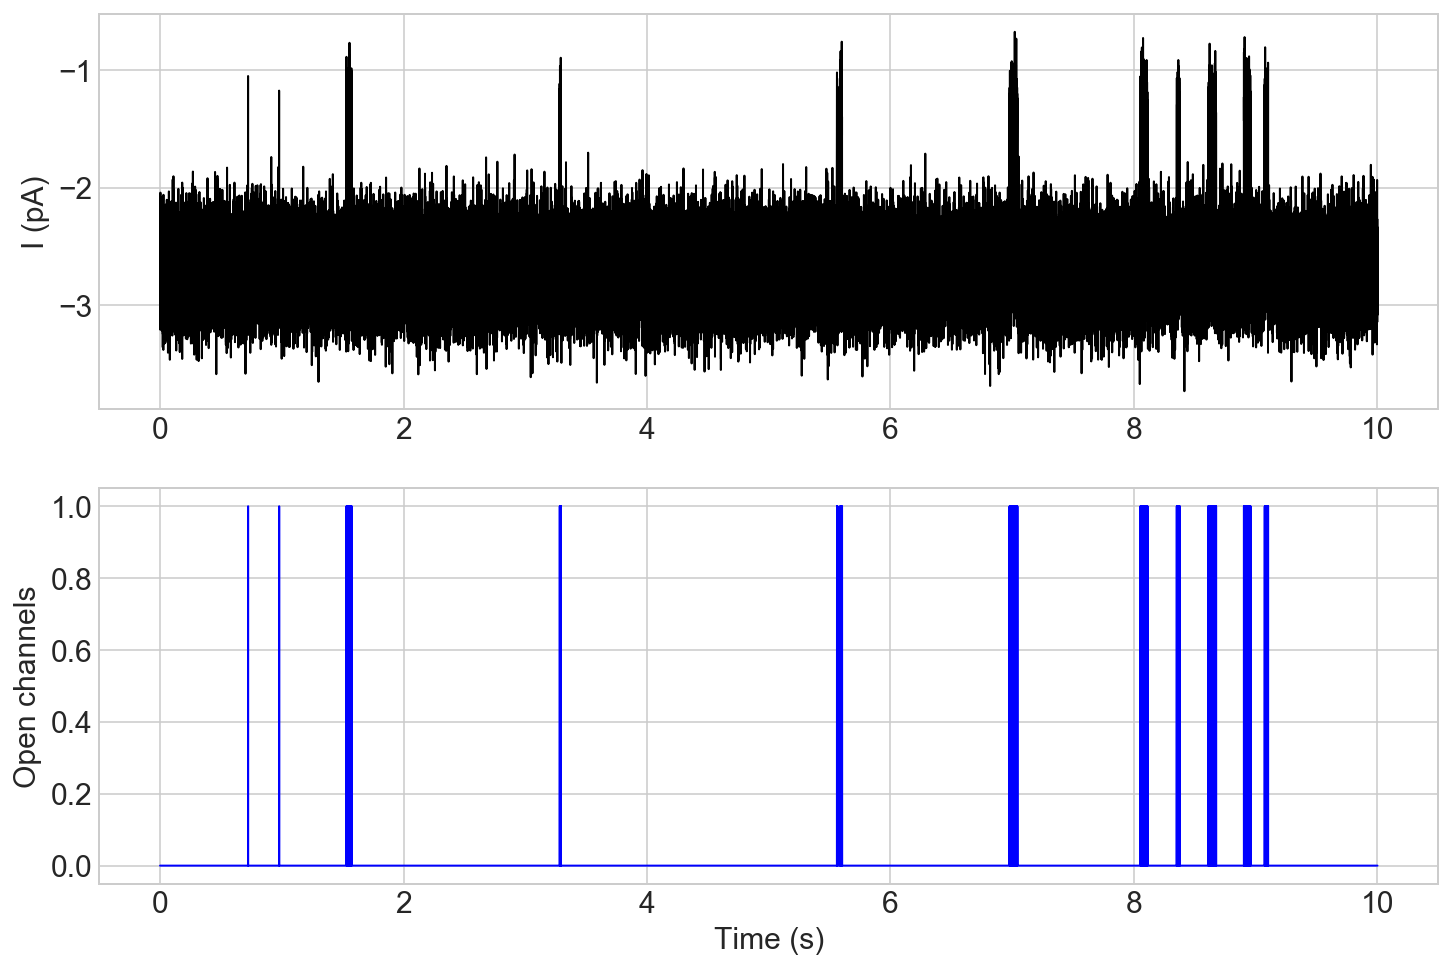

Signal Batch (fragment):  1


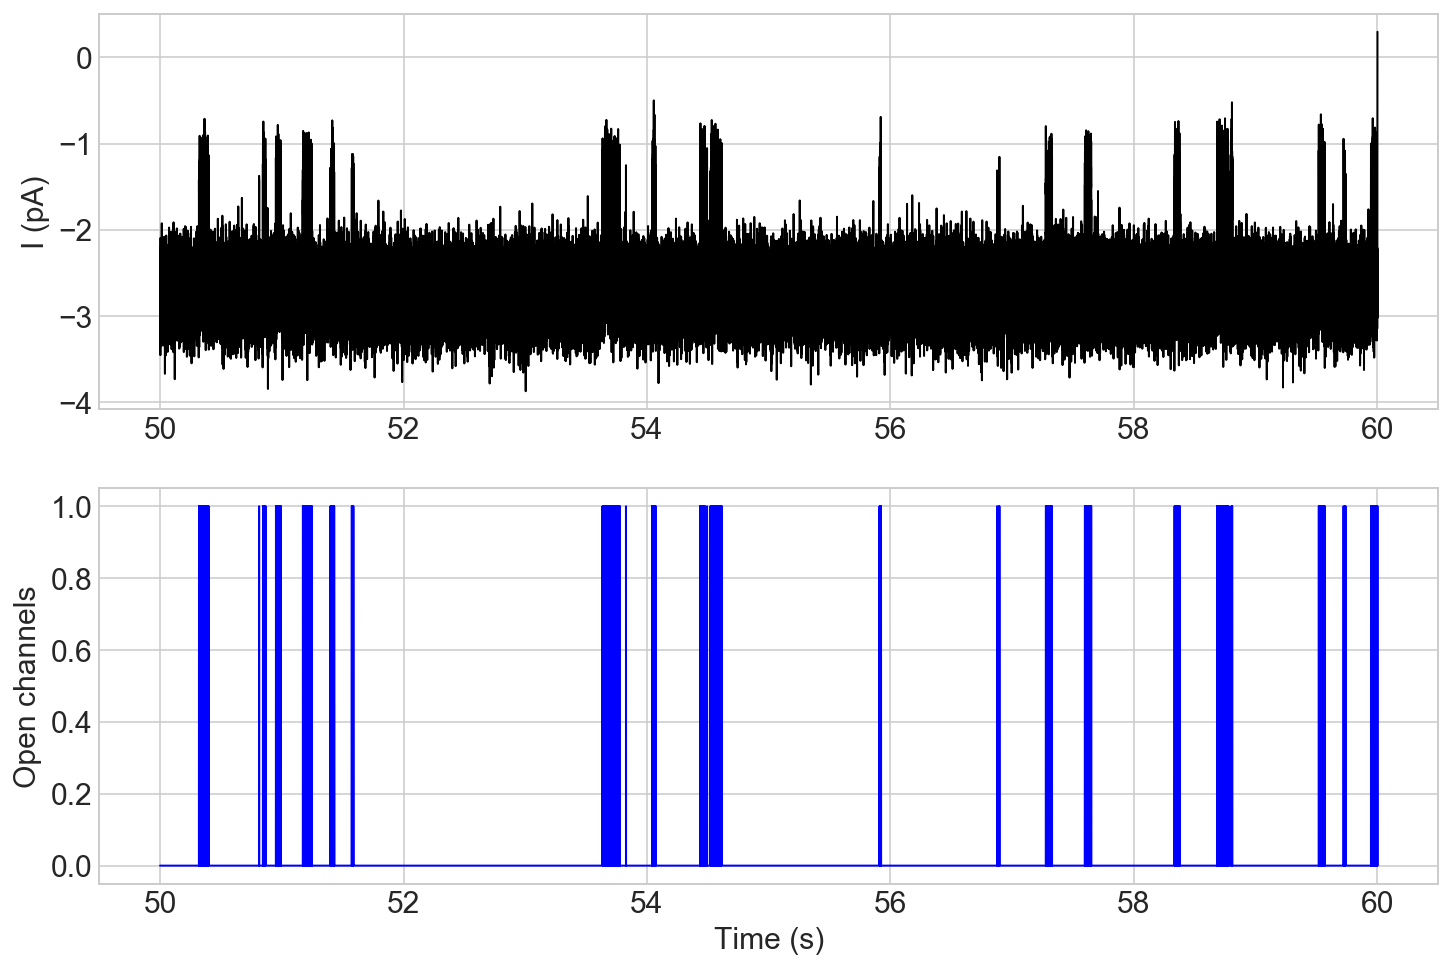

Signal Batch (fragment):  2


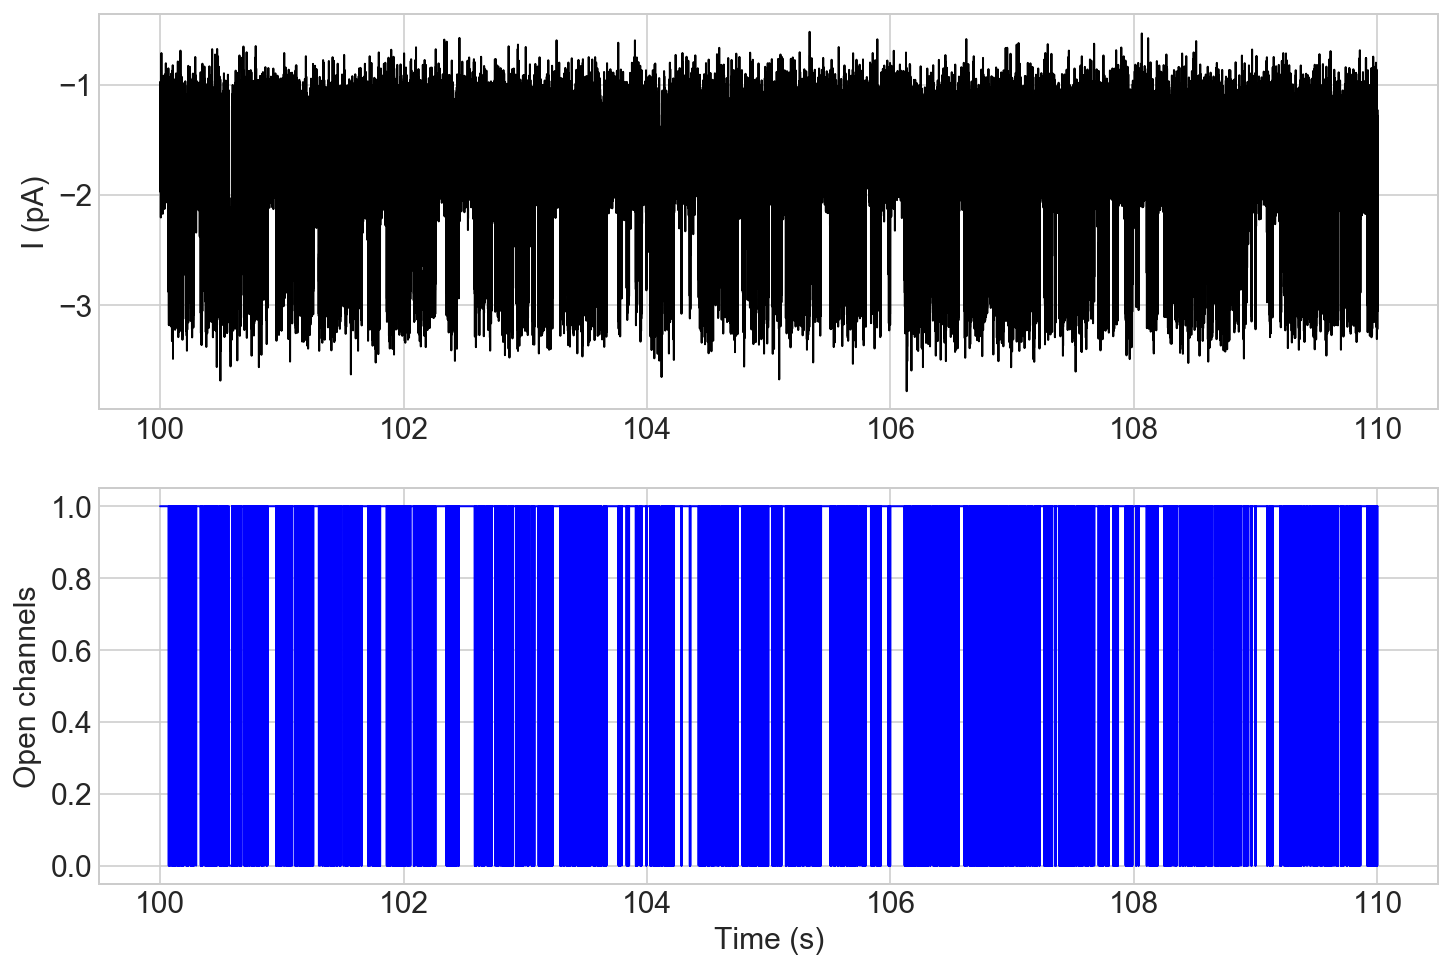

Signal Batch (fragment):  3


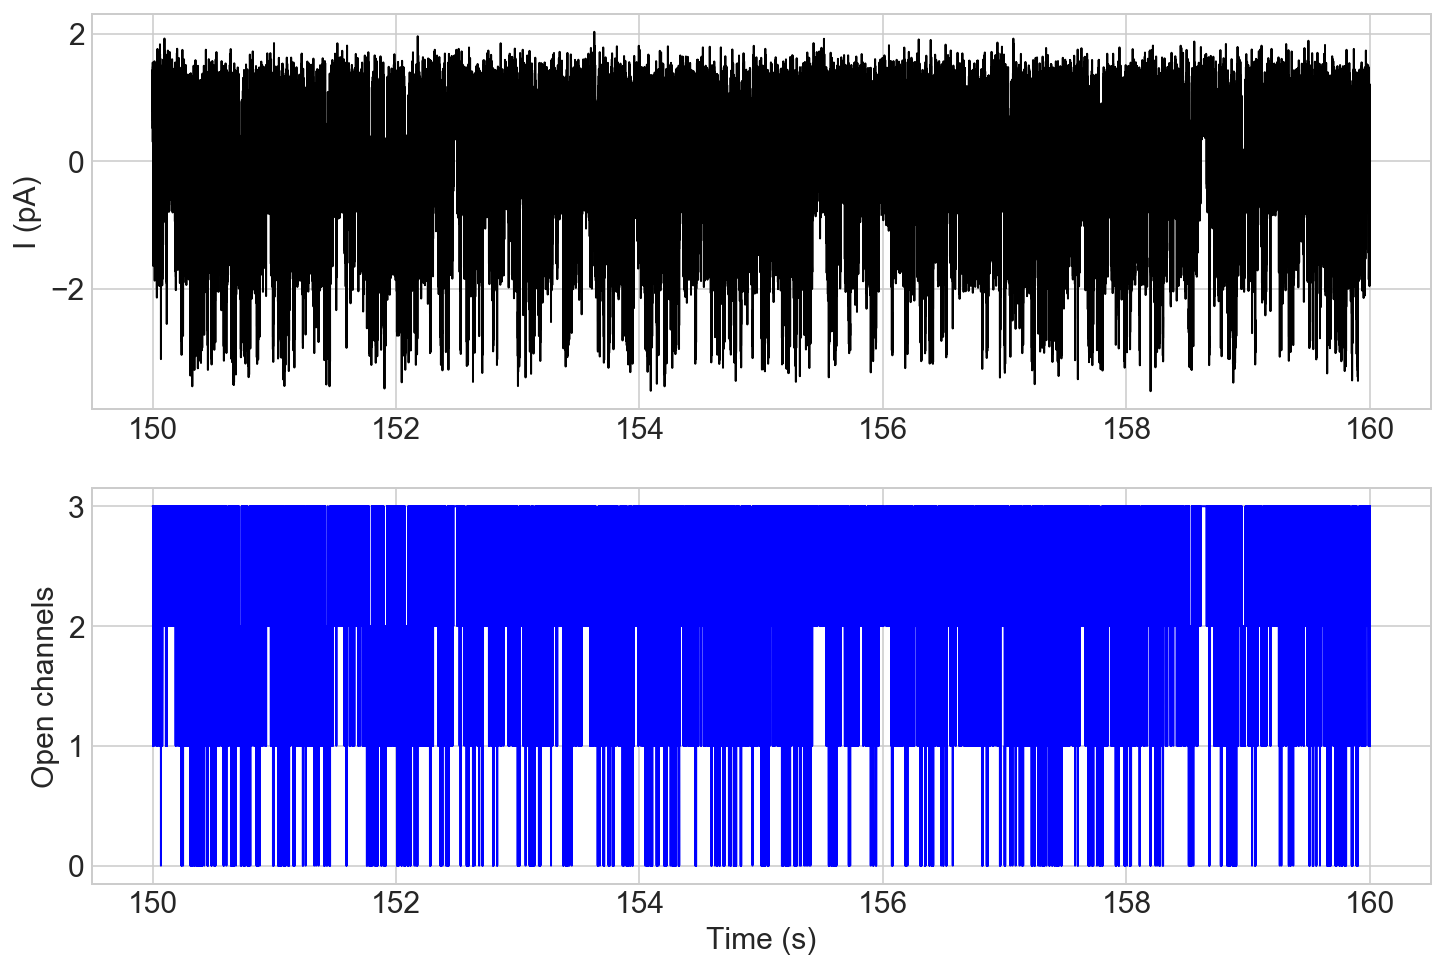

Signal Batch (fragment):  4


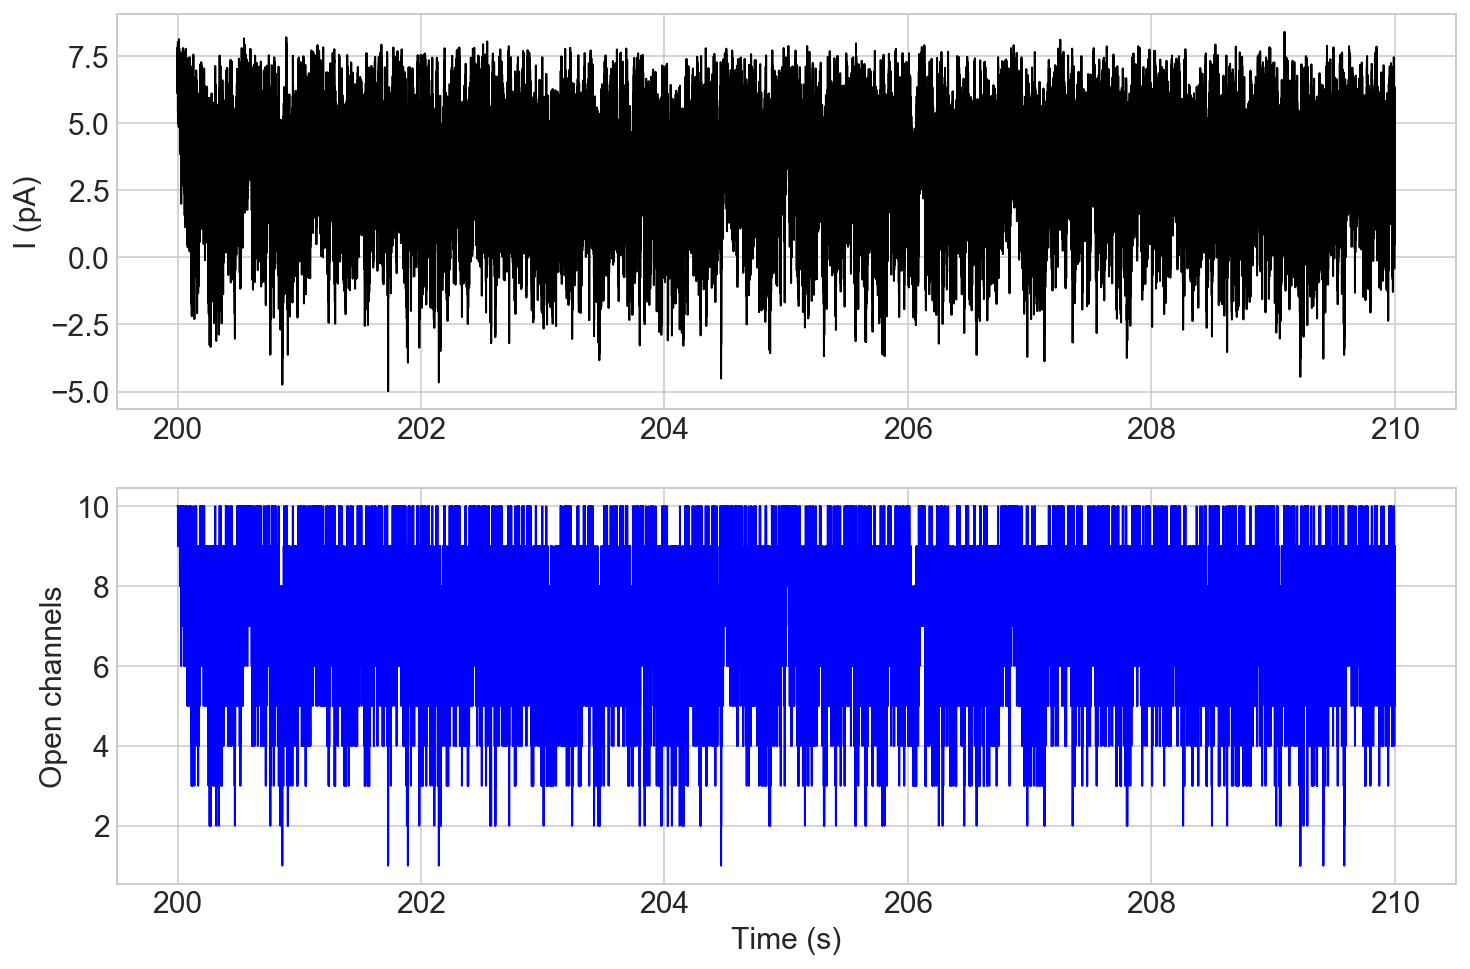

Signal Batch (fragment):  5


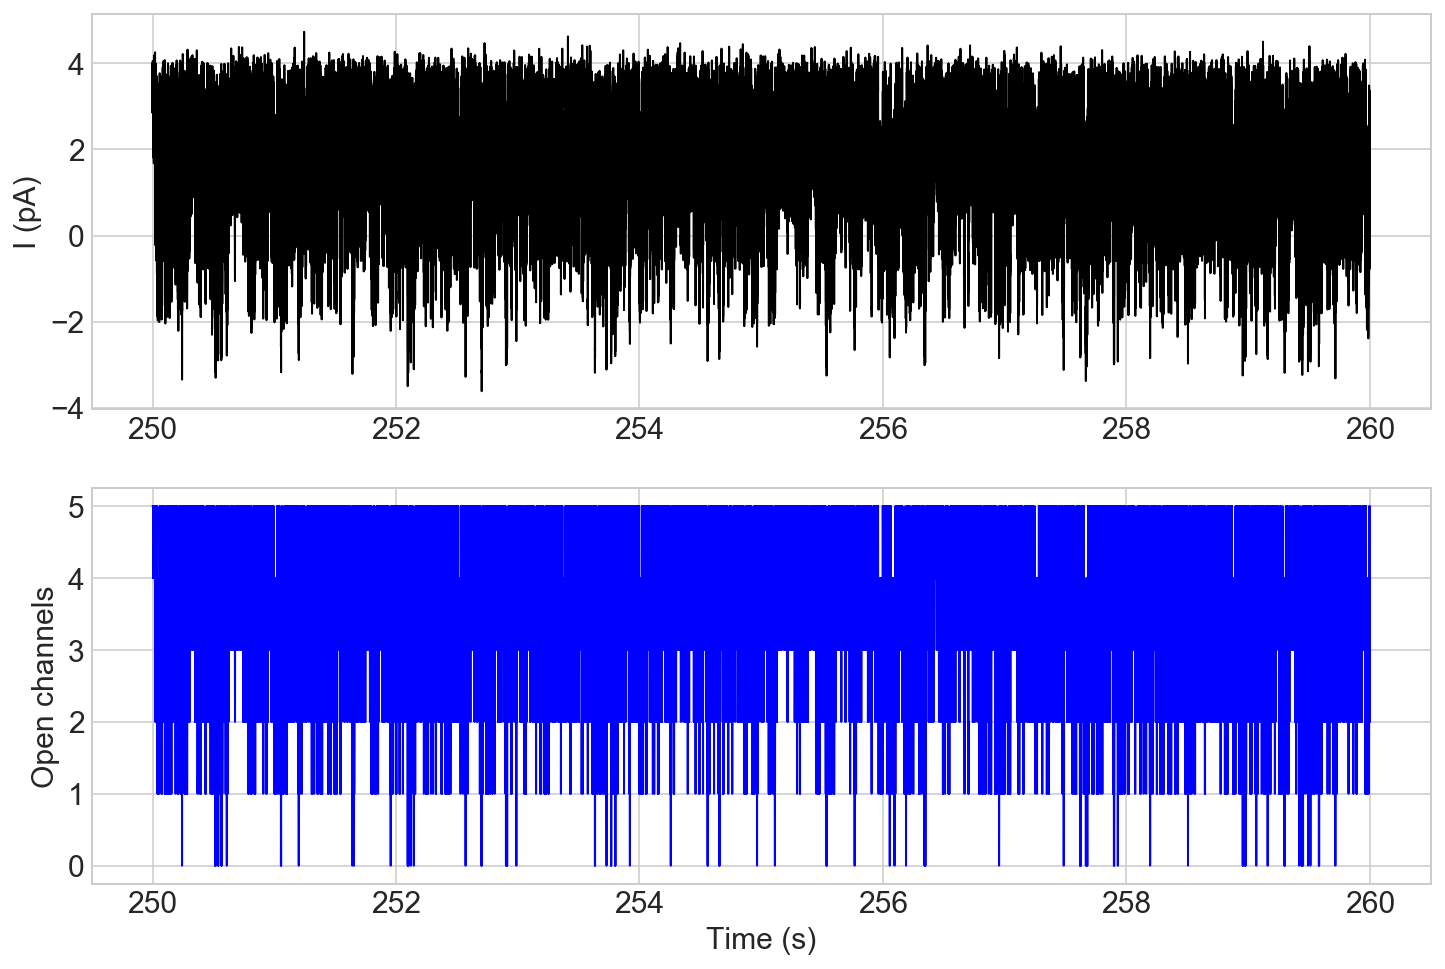

Signal Batch (fragment):  6


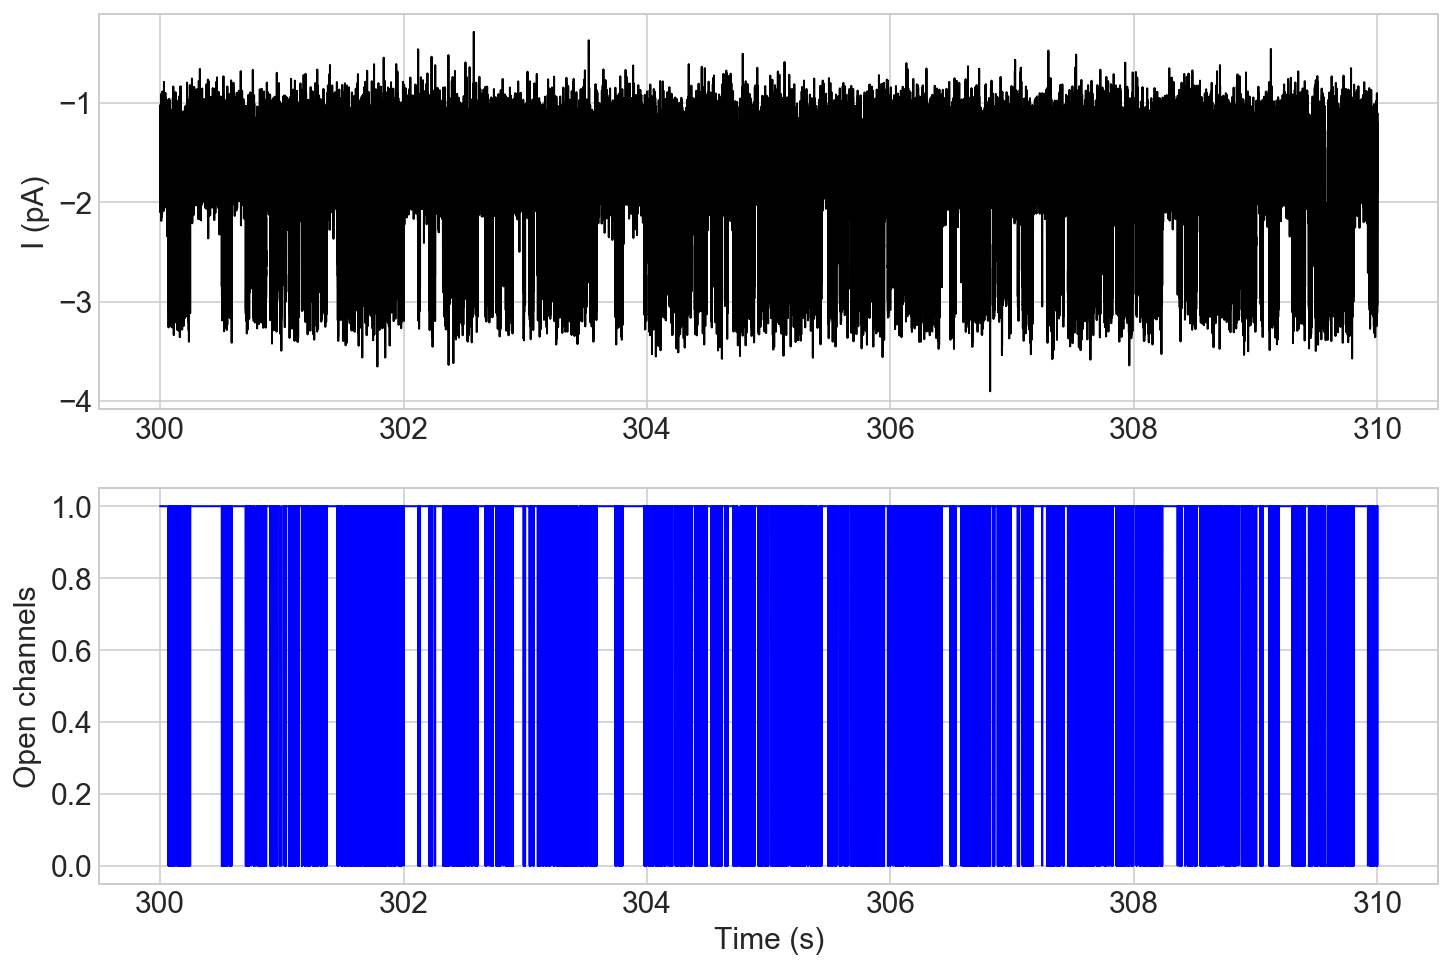

Signal Batch (fragment):  7


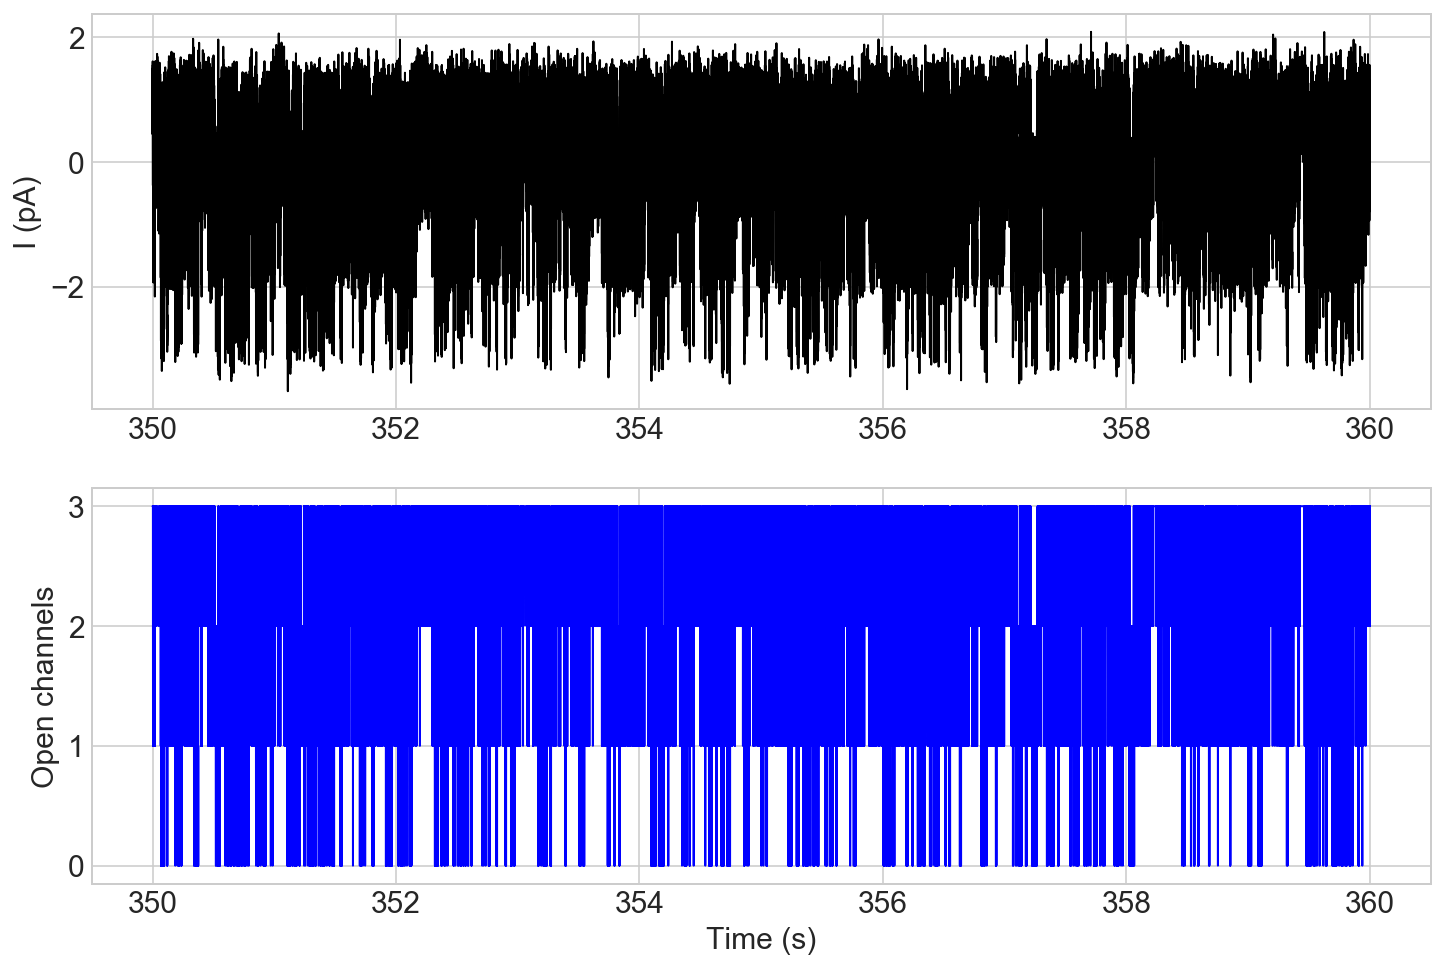

Signal Batch (fragment):  8


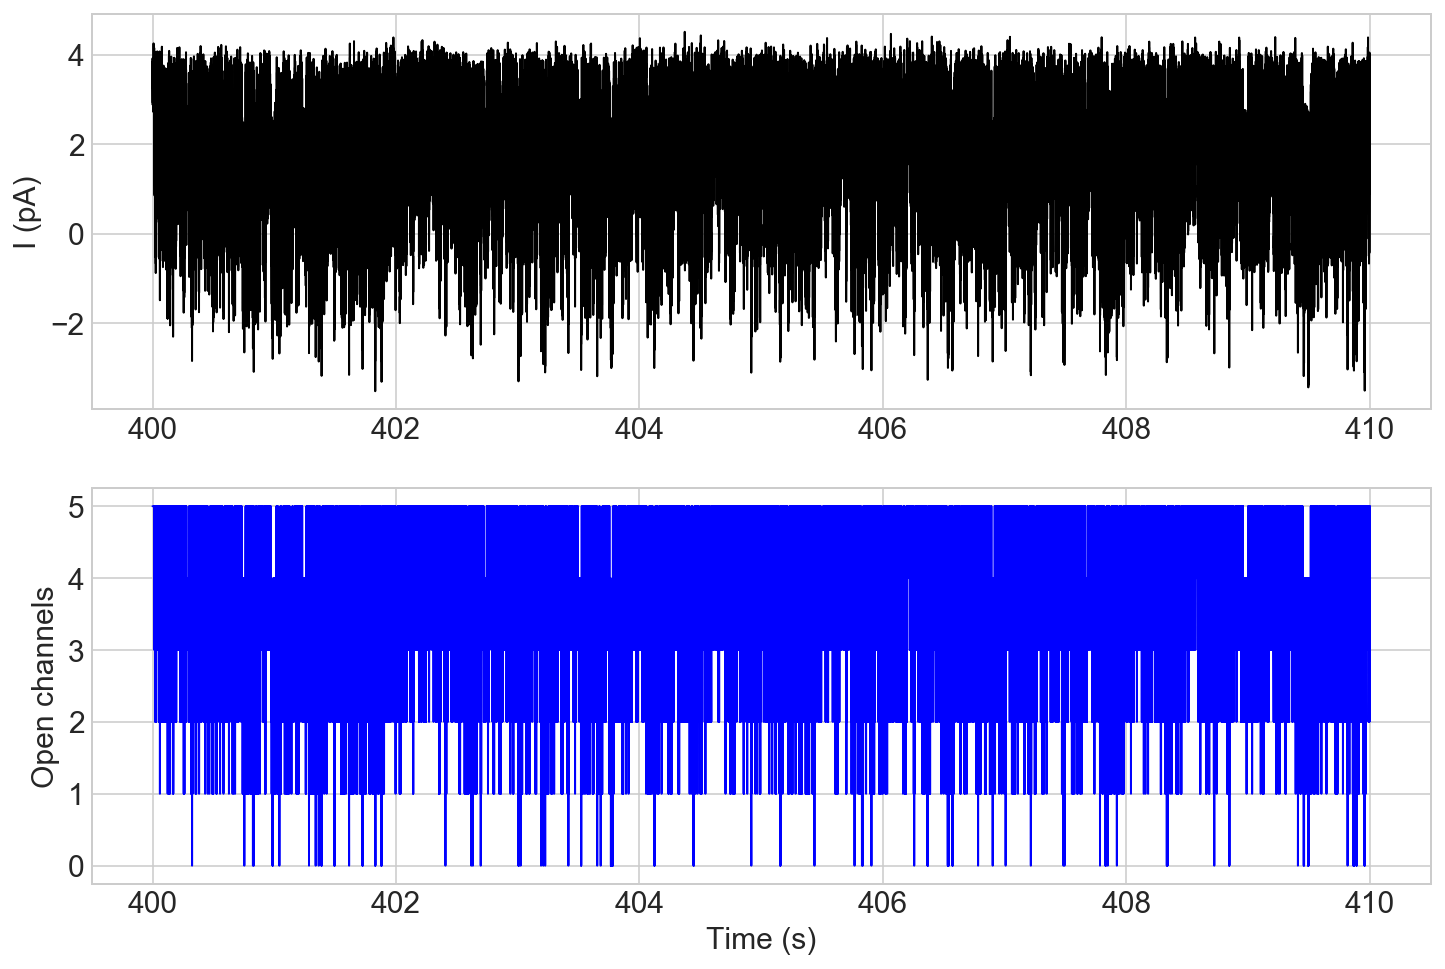

Signal Batch (fragment):  9


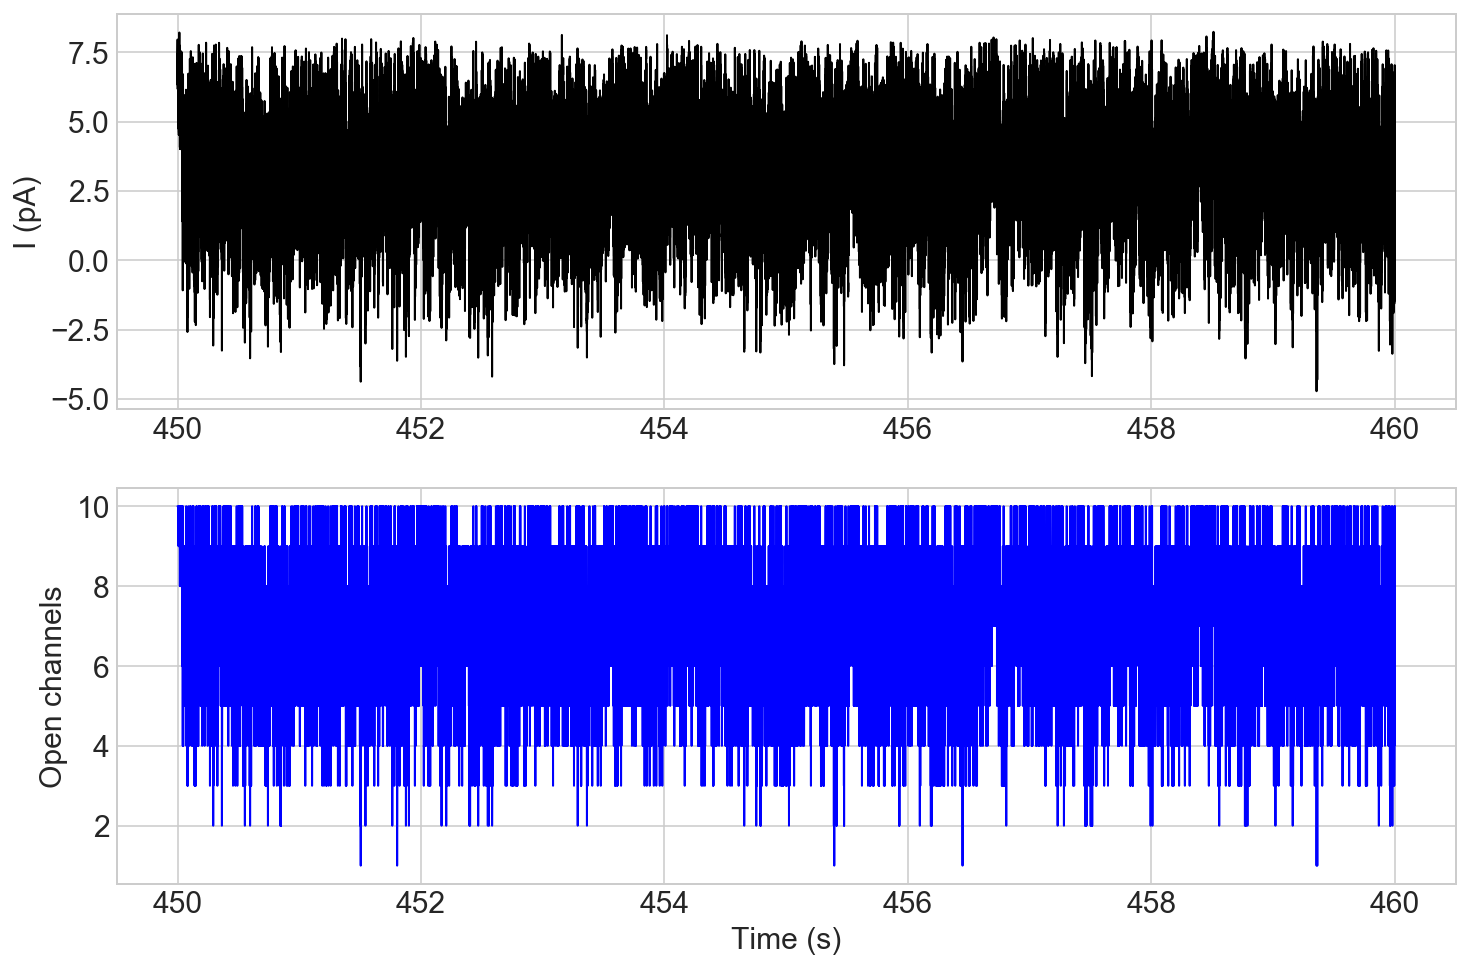

In [14]:
def visulize_data(df_train):
    print('Number of training batches:', len(df_train)/500000)

    for i in range(int(len(df_train)/500000)):
        print('Signal Batch (fragment): ', i)
        fig, ax1 = plt.subplots(2, 1, figsize=(12,8))
        ax1[0].plot(df_train['time'].iloc[i*500000:i*500000+100000], 
                df_train['signal'].iloc[i*500000:i*500000+100000],
                'k', lw=1)
        ax1[0].set_xlabel('')
        ax1[0].set_ylabel('I (pA)')

        ax1[1].plot(df_train['time'].iloc[i*500000:i*500000+100000],
                    df_train['open_channels'].iloc[i*500000:i*500000+100000],
                    'b', lw=1)
        ax1[1].set_xlabel('Time (s)')
        ax1[1].set_ylabel('Open channels')

        plt.show()

visulize_data(ions.train)

In [30]:
ions.data

,time,signal,open_channels,label,batch_idx,signal_scaled
0,0.000100,-2.7600,0.0,train,1,0.318263
1,0.000200,-2.8557,0.0,train,1,0.287025
2,0.000300,-2.4074,0.0,train,1,0.433361
3,0.000400,-3.1404,0.0,train,1,0.194092
4,0.000500,-3.1525,0.0,train,1,0.190142
...,...,...,...,...,...,...
6999995,699.999573,-2.9092,NaN,test,70,0.160794
6999996,699.999695,-2.7422,NaN,test,70,0.192686
6999997,699.999817,-2.8285,NaN,test,70,0.176206
6999998,699.999878,-2.9092,NaN,test,70,0.160794


# Execution

In [86]:
ions = KaggleCompete()
# train and test concatenated
ions.label_batch()
ions.scale_batch()
# train and test splited
ions.data_split()
# ions.X_train, ions.X_test = ions.normalize(ions.X_train, ions.X_test)
ions.X_train = ions.feature_engineering(ions.X_train)
ions.X_test = ions.feature_engineering(ions.X_test)

ions.feature_selection(drop_list=['time', 'label', 'batch_idx', 'group'])

In [87]:
lgb_model = model_lgb(ions.X_train, ions.y_train)
ions.submit_result(lgb_model)

Training until validation scores don't improve for 150 rounds
[50]	valid_0's multi_logloss: 0.107224
[100]	valid_0's multi_logloss: 0.0935266
[150]	valid_0's multi_logloss: 0.0923753
[200]	valid_0's multi_logloss: 0.353134
[250]	valid_0's multi_logloss: 0.495052
Early stopping, best iteration is:
[147]	valid_0's multi_logloss: 0.0923438
Validation score: 0.9320424729882588


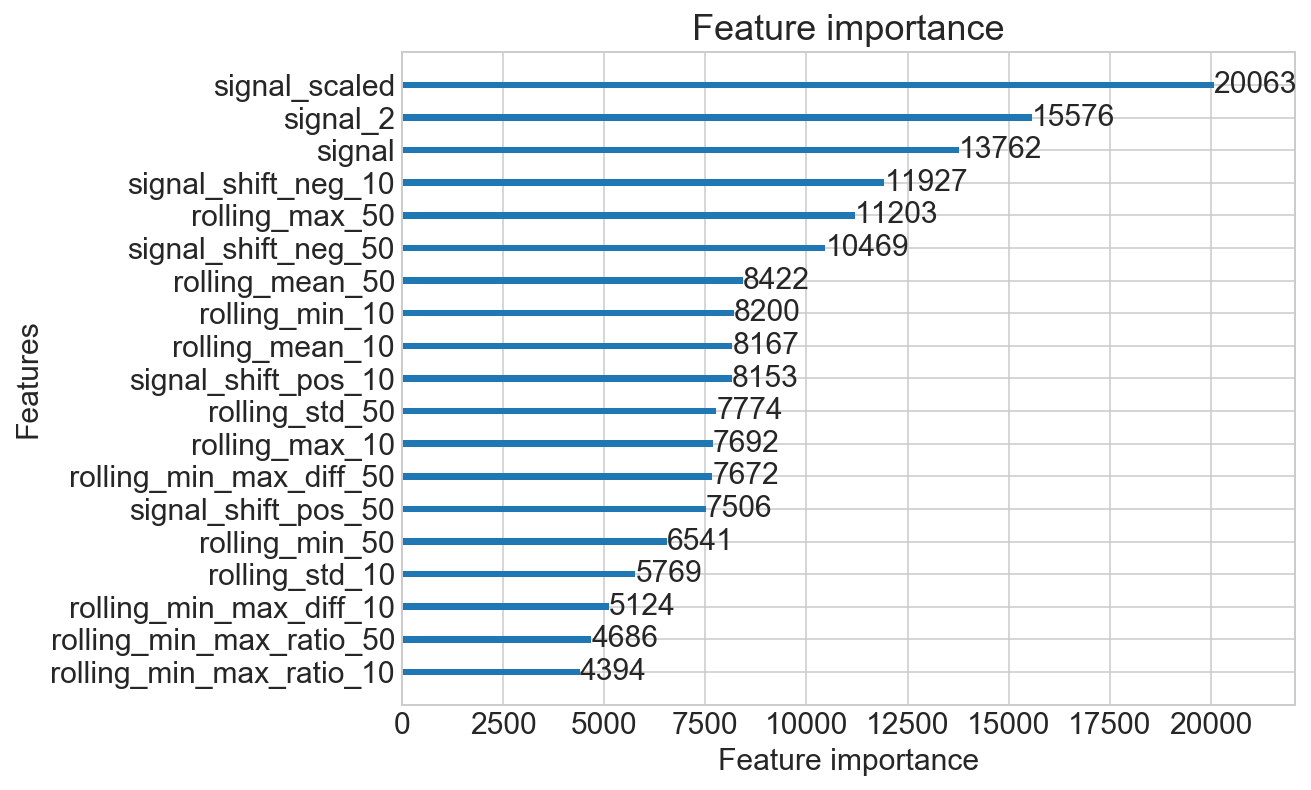

In [88]:
lgb.plot_importance(lgb_model, figsize=(8, 6))
plt.show()

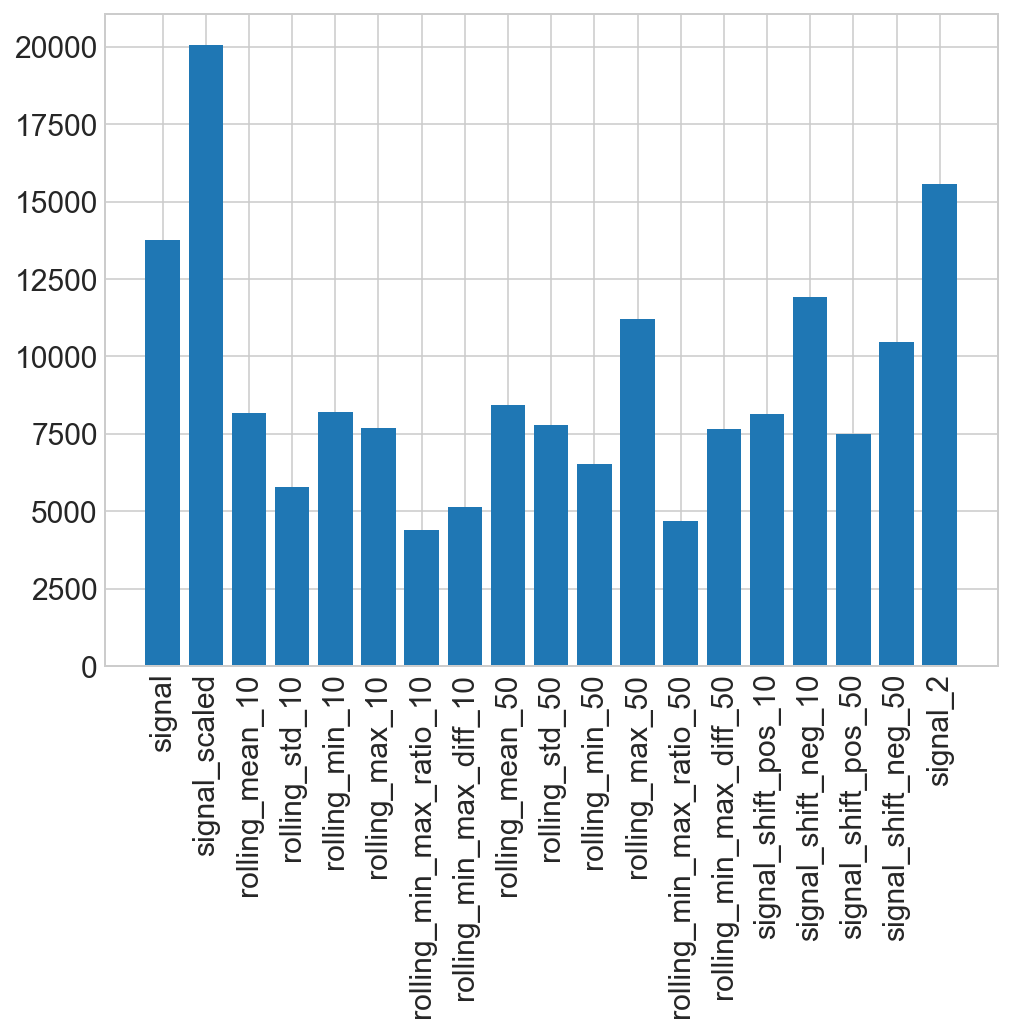

In [89]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.bar(ions.X_test.columns, lgb_model.feature_importances_)
ax.set_xticklabels(ions.X_test.columns, rotation=90)
plt.show()